In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from scipy import interpolate
from tqdm import tqdm

#### [1] Используя функцию make_blobs с любым random state, сгенерировать датасет df1, в котором есть три класса с размером каждого класса 1000 объектов и 16 количественных (недискретных) признаков. Распределения двух из трех классов должны значительно перекрывать друг друга, тогда как третий класс должен быть на расстоянии от первых двух классов.

# Не забываем повторять шаги задания 1:
- ключевые характеристики датасета
- корреляции
- визуализация на всех парах переменных

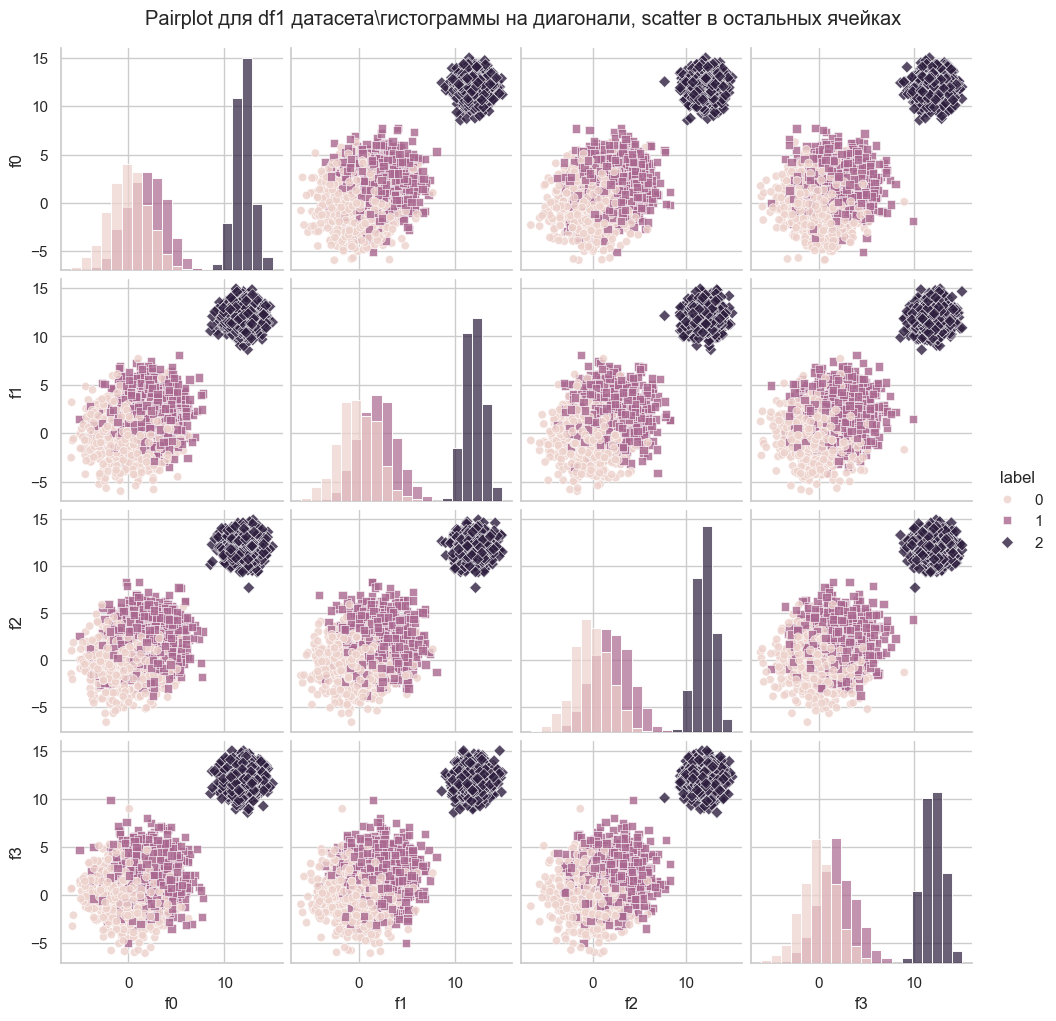

In [ ]:
RANDOM_STATE = 42
n_classes = 3
n_per_class = 1000
n_features = 16

centers = []
centers.append(np.zeros(n_features))                 # класс 0 в начале
centers.append(np.ones(n_features) * 2)            # класс 1 вблизи класса 0 с некоторым наложением
centers.append(np.ones(n_features) * 12.0)            # класс 2 удаленный от первых двух

X, y = make_blobs(n_samples=[n_per_class]*n_classes, centers=centers,
                  cluster_std=[2.0, 2.0, 1.0], n_features=n_features,
                  random_state=RANDOM_STATE)

cols = [f'f{i}' for i in range(n_features)]
df1 = pd.DataFrame(X, columns=cols)
df1['label'] = y

# Pairplot с цветом и формой точек по target_name
sns.pairplot(
    df1,
    vars=cols[:4],
    hue="label",       # цвет по классу
    markers=["o", "s", "D"], # разные формы: кружок квадрат ромб
    diag_kind="hist",        # диагональ = гистограммы
    diag_kws={"bins": 20, "alpha": 0.7}, # 20 разбиений полупрозрачные
    plot_kws={"alpha": 0.8}  # прозрачность точек
)

plt.suptitle("Pairplot для df1 датасета\гистограммы на диагонали, scatter в остальных ячейках", y=1.02)
plt.show()

In [11]:
df1.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,label
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,4.623050,4.629328,4.639331,4.650681,4.734530,4.707281,4.675234,4.624593,4.683792,4.658916,4.648621,4.716342,4.681237,4.609180,4.672050,4.689201,1.000000
std,5.541300,5.544577,5.562817,5.487441,5.471341,5.503011,5.558153,5.541665,5.529571,5.484925,5.538285,5.526214,5.504672,5.548577,5.571274,5.501735,0.816633
min,-5.946612,-5.987413,-6.642229,-6.067979,-6.483028,-6.659008,-6.615800,-5.842701,-7.673311,-6.089313,-7.844801,-7.376731,-6.751158,-7.202170,-6.500667,-6.465131,0.000000
25%,0.196888,0.191986,0.194763,0.300709,0.464129,0.338319,0.235355,0.165205,0.287954,0.337133,0.168991,0.317432,0.338386,0.182010,0.238924,0.352566,0.000000
50%,2.539583,2.471364,2.506767,2.359098,2.632523,2.563873,2.471647,2.461927,2.553922,2.496454,2.535975,2.629902,2.563971,2.387577,2.474850,2.543410,1.000000
75%,11.340937,11.314537,11.372775,11.175368,11.298946,11.305552,11.437625,11.259931,11.329463,11.267908,11.268501,11.343349,11.278738,11.330092,11.379903,11.313220,2.000000
max,15.019653,14.933403,14.955533,15.002652,15.602415,15.335268,15.536532,15.139114,15.727833,14.923554,14.951197,14.935967,14.927369,14.761056,15.380614,15.222928,2.000000


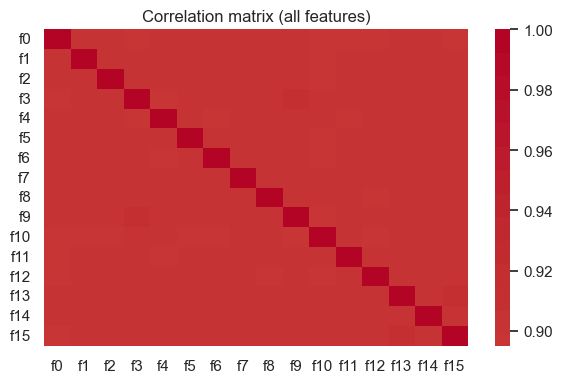

In [15]:
corr = df1[cols].corr()

sns.set(style='whitegrid')
plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation matrix (all features)')
plt.tight_layout()
plt.show()


#### [2] На основе созданного в пункте [1] датасета df1 сгенерировать отдельные дополнительные датасеты (df2, df5, df10…), в которых объекты одного класса (который имеет пересечение с другим) повторены 2 раза, 5 раз, 10 раз, 20 раз, 50 раз, 100 раз, 1000 раз, 10k раз, а количество объектов в остальных классах осталось неизменно.

In [17]:
repeat_factors = [1,2,5,10,20,50,100,1000,10000]
# repeat_factors[1] == df1, repeat_factors[2] == df2 ...

datasets = {}
for k in repeat_factors:
    if k == 1:
        datasets[f'df1'] = df1.copy().reset_index(drop=True)
        continue
    # берем класс для повтарения
    df_repeat = df1[df1['label']==0]
    df_rest = df1[df1['label']!=0]
    # повторить df_repeat k times -> стакаем копиии игнорируя индексы
    repeated = pd.concat([df_repeat]*k, ignore_index=True)
    new_df = pd.concat([repeated, df_rest], ignore_index=True)
    # при этом сохраняем лейблы 0,1,2
    datasets[f'df{k}'] = new_df.reset_index(drop=True)

print('Датасеты: ', list(datasets.keys()))


Датасеты:  ['df1', 'df2', 'df5', 'df10', 'df20', 'df50', 'df100', 'df1000', 'df10000']
